# DecisionTree
このnotebookでは決定木・バギング・ブースティングなどの手法についてscikit-learnを使って振る舞いを確認します。


In [1]:
#ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ヘルパー関数
def get_dataset_for_classification(mode='easy'):
    from numpy.random import default_rng
    rng = default_rng(seed=0)  # 今回はデータセットの乱数を固定させます。

    num_signal = 20  # 生成するシグナルイベントの数
    num_background = 40  # 生成するバックグラウンドイベントの数

    # データ点の生成
    if mode == 'easy':
        # 平均(x1,x2) = (0.0, 0.0)、分散=0.5の２次元ガウス分布
        x_sig = rng.multivariate_normal(mean=[0, 0],
                                        cov=[[0.5, 0], [0, 0.5]],
                                        size=num_signal)
        # (-3, +3)の一様分布
        x_bg = rng.uniform(low=-3, high=3, size=(num_background, 2))
    elif mode == 'difficult':
        num_background = 20
        x_sig = rng.multivariate_normal(mean=[-0.25, 0.25],
                                        cov=[[1.0, 0.99], [0.99, 1.0]],
                                        size=num_signal)
        x_bg = rng.multivariate_normal(mean=[0.25, -0.25],
                                        cov=[[1.0, 0.99], [0.99, 1.0]],
                                        size=num_background)

    t_sig = np.ones((num_signal, 1))  # Signalは1にラベリング
    t_bg = np.zeros((num_background, 1))  # Backgroundは0にラベリング

    # 2つのラベルを持つ学習データを1つにまとめる
    x = np.concatenate([x_sig, x_bg])
    t = np.concatenate([t_sig, t_bg])

    # データをランダムに並び替える
    p = rng.permutation(len(x))
    x, t = x[p], t[p]

    return x, t


def get_dataset_for_regression():
    from numpy.random import default_rng
    rng = default_rng(seed=0)  # 今回はデータセットの乱数を固定させます。

    num_samples = 30

    x = np.linspace(-np.pi, np.pi, num_samples)
    t = np.sin(x) + 0.2 * rng.normal(0., 1., num_samples)
    x = x[:, np.newaxis]
    t = t[:, np.newaxis]

    # データをランダムに並び替える
    p = rng.permutation(len(x))
    x, t = x[p], t[p]

    return x, t


# classification用データセットのプロット
def plot_datapoint(x, t, ax=plt):
    # シグナル/バックグラウンドの抽出
    x_sig = x[t[:, 0] == 1]  # シグナルのラベルだけを抽出
    x_bg = x[t[:, 0] == 0]  # バックグラウンドのラベルだけを抽出

    # プロット
    ax.scatter(x_sig[:, 0], x_sig[:, 1], label='Signal', c='red', s=10)  # シグナルをプロット
    ax.scatter(x_bg[:, 0], x_bg[:, 1], label='Background', c='blue', s=10)  # バックグラウンドをプロット
    if hasattr(ax, 'xlabel'):
        ax.xlabel('x0')  # x軸ラベルの設定
        ax.ylabel('x1')  # y軸ラベルの設定
        ax.legend()  # legendの表示


# classification用 機械学習モデル予測の等高線プロット
def plot_prediction(prediction, ax=plt):
    # 等高線を描くためのメッシュの生成
    x1, x2 = np.mgrid[-3:3:100j, -3:3:100j]
    x = np.array([x1.flatten(), x2.flatten()]).T

    # 関数predictionを使って入力xから出力yを計算し、等高線プロットを作成
    y = prediction(x)
    cs = ax.tricontour(x1.flatten(), x2.flatten(), y.flatten(), levels=[0.5], extend='max')
    cs = ax.contourf(x1, x2, y.reshape((100, 100)), levels=[-0.1, 0.5, 1.5], alpha=0.05, colors=['blue', 'red'])


## 使用するToy データセット

### For classification

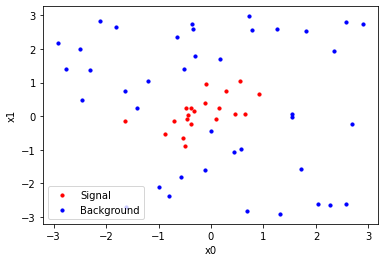

In [3]:
# データ点の取得
x, t = get_dataset_for_classification()

# プロット
plot_datapoint(x, t)

### For regression

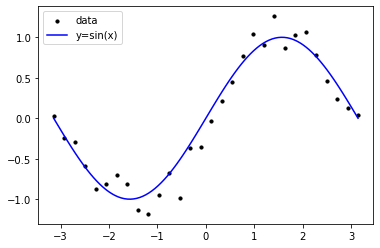

In [4]:
# データ点の取得
x, t = get_dataset_for_regression()

# プロット
x_grid = np.linspace(-np.pi, np.pi, 100)[:, np.newaxis]
plt.scatter(x, t, s=10, c='black', label='data')  # データ点のプロット
plt.plot(x_grid, np.sin(x_grid), c='blue', label='y=sin(x)')
plt.legend()
plt.show()

# 決定木 (Decision Tree)
## For classification

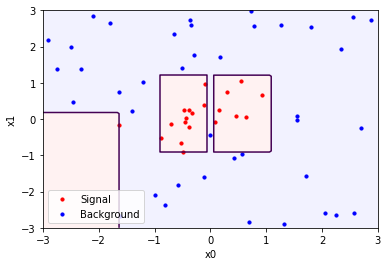

In [5]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(
    criterion='gini',
    # criterion='entropy',
    splitter='best',
    max_depth=7,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=1,
)

# データ点の取得
x, t = get_dataset_for_classification()

# フィット
_ = model.fit(x, t)

# プロット
plot_prediction(model.predict)
plot_datapoint(x, t)

### 決定木の中身

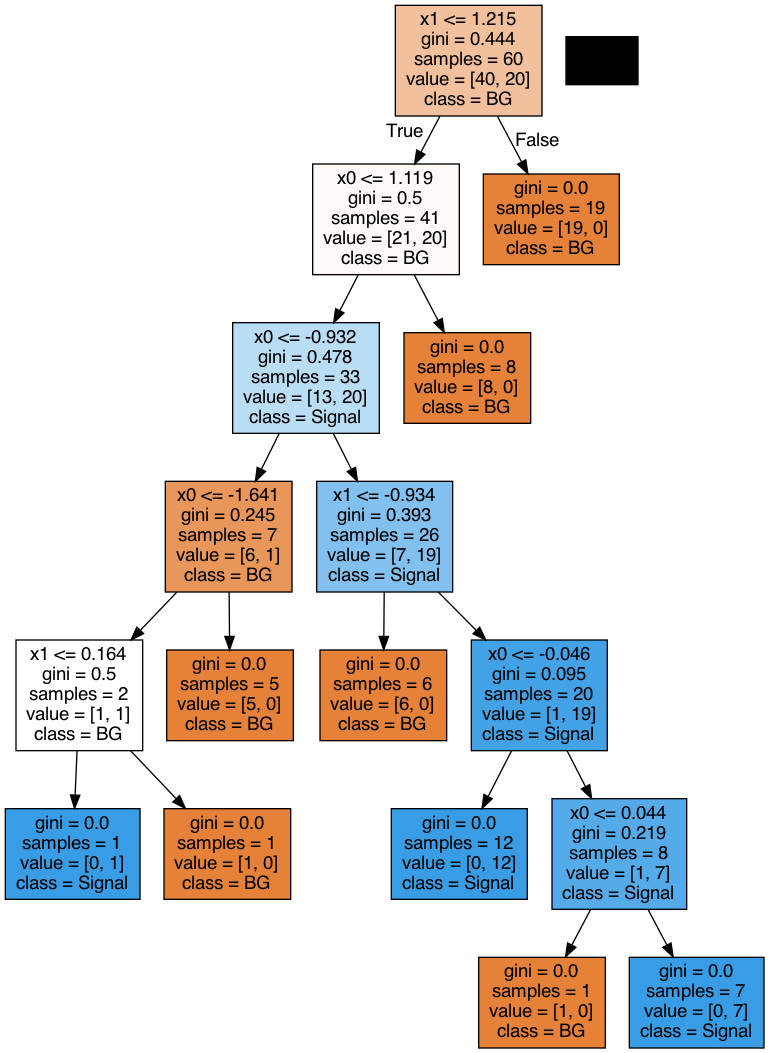

In [6]:
from sklearn.tree import export_graphviz
dot_data = export_graphviz(
    model,
    out_file=None,
    filled=True,
    feature_names=['x0', 'x1'],
    class_names=['BG', 'Signal'],
)

import pydotplus as pdp
graph = pdp.graph_from_dot_data(dot_data)

from IPython.display import Image
Image(graph.create_png())

# Export as png file
# graph.write_png('tmp.png')

### 木の深さを変えたときの予測の変化

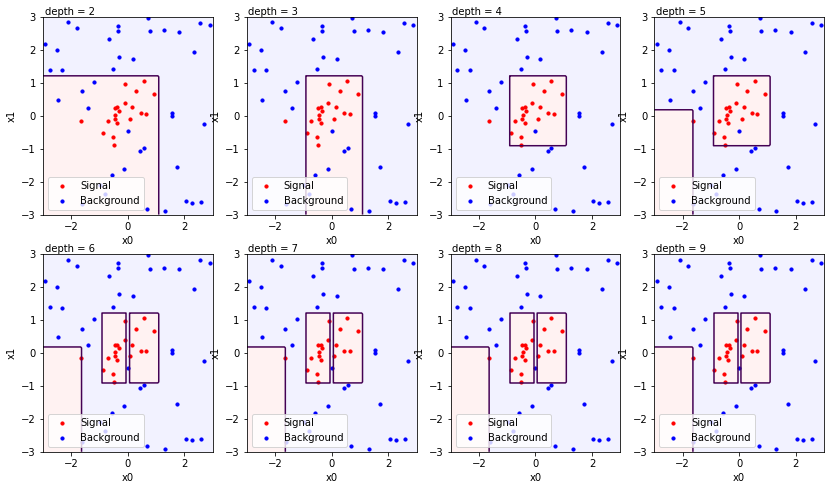

In [7]:
# データ点の取得
x, t = get_dataset_for_classification()

fig = plt.figure(figsize=(14, 8))
for i, depth in enumerate([2, 3, 4, 5, 6, 7, 8, 9]):
    ax = fig.add_subplot(2, 4, 1 + i)

    from sklearn.tree import DecisionTreeClassifier
    model = DecisionTreeClassifier(
        criterion='gini',
        # criterion='entropy',
        splitter='best',
        max_depth=depth,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=1,
    )

    # フィット
    _ = model.fit(x, t)

    # プロット
    plot_prediction(model.predict, ax)
    plot_datapoint(x, t)

    ax.text(0.01, 1.01, f'depth = {depth}', transform=ax.transAxes)


## For Regression

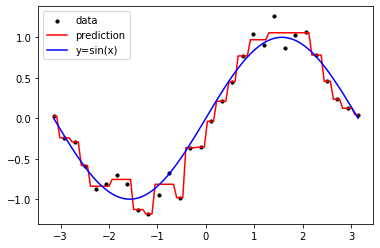

In [8]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(
    criterion='squared_error',
    splitter='best',
    max_depth=6,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=1,
    random_state=1,
)

# データ点の取得
x, t = get_dataset_for_regression()

# フィット
_ = model.fit(x, t)

# プロット
x_grid = np.linspace(-np.pi, np.pi, 100)[:, np.newaxis]
plt.scatter(x, t, s=10, c='black', label='data')  # データ点のプロット
plt.plot(x_grid, model.predict(x_grid), c='red', label='prediction')
plt.plot(x_grid, np.sin(x_grid), c='blue', label='y=sin(x)')
plt.legend()
plt.show()

### 決定木の中身

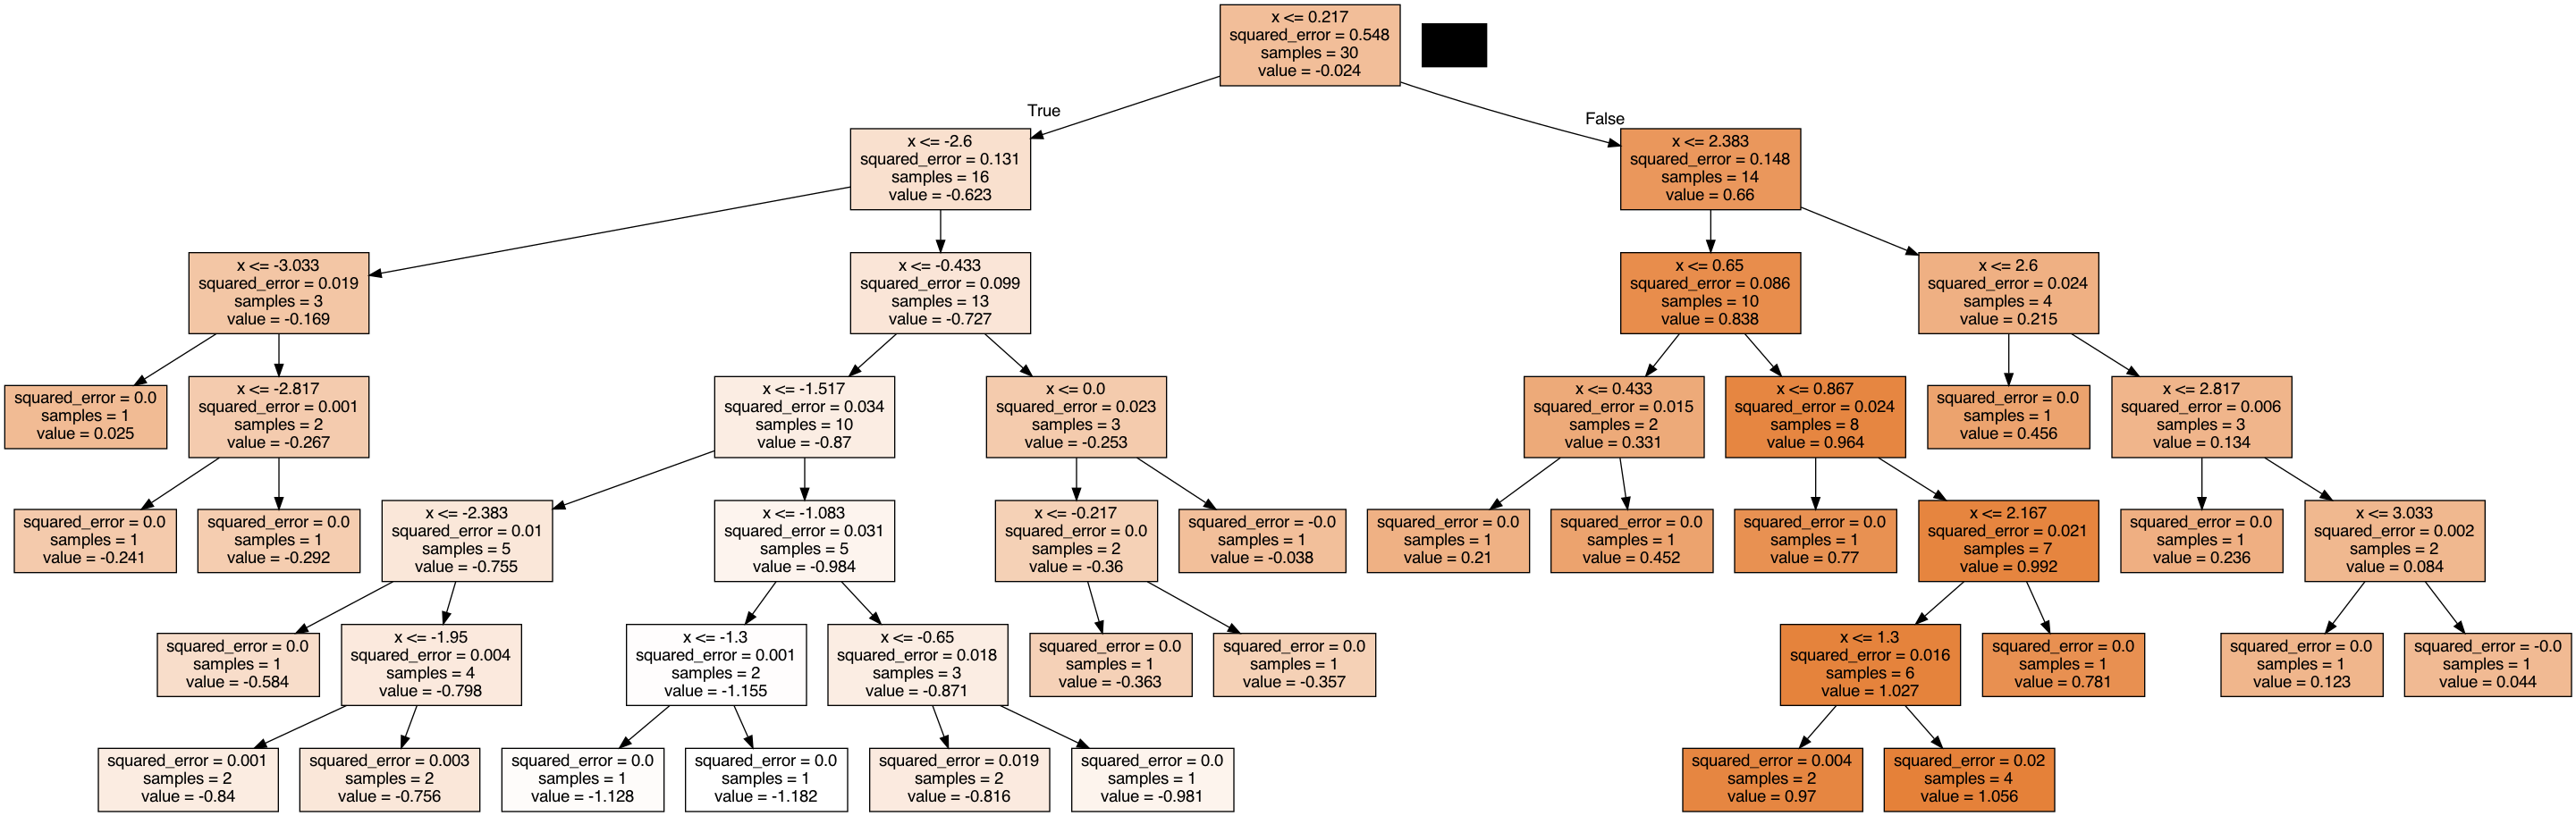

In [9]:
from sklearn.tree import export_graphviz
dot_data = export_graphviz(
    model,
    out_file=None,
    filled=True,
    feature_names=['x'],
)

import pydotplus as pdp
graph = pdp.graph_from_dot_data(dot_data)

from IPython.display import Image
Image(graph.create_png())

# Export as png file
# graph.write_png('tmp.png')

### 木の深さを変えたときの予測の変化

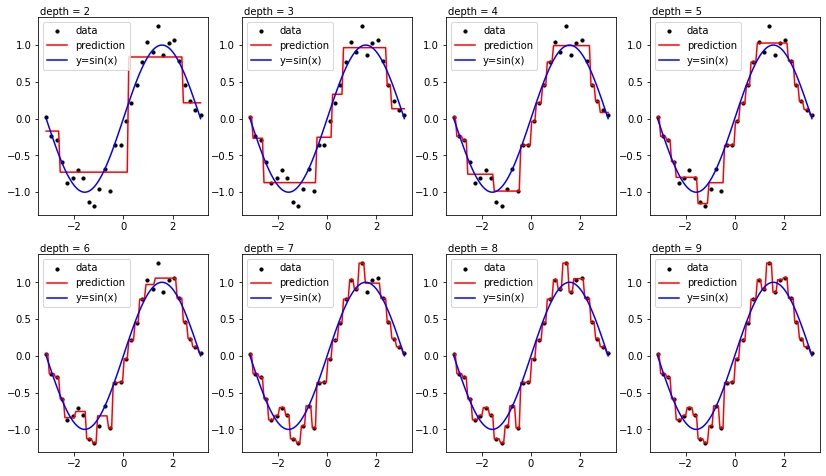

In [10]:
# データ点の取得
x, t = get_dataset_for_regression()
x_grid = np.linspace(-np.pi, np.pi, 100)[:, np.newaxis]

fig = plt.figure(figsize=(14, 8))
for i, depth in enumerate([2, 3, 4, 5, 6, 7, 8, 9]):
    ax = fig.add_subplot(2, 4, 1 + i)

    from sklearn.tree import DecisionTreeRegressor
    model = DecisionTreeRegressor(
        criterion='squared_error',
        splitter='best',
        max_depth=depth,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=1,
        random_state=1,
    )

    # フィット
    _ = model.fit(x, t)

    # プロット
    ax.scatter(x, t, s=10, c='black', label='data')  # データ点のプロット
    ax.plot(x_grid, model.predict(x_grid), c='red', label='prediction')
    ax.plot(x_grid, np.sin(x_grid), c='blue', label='y=sin(x)')
    ax.legend()

    ax.text(0.01, 1.01, f'depth = {depth}', transform=ax.transAxes)


## 決定木が苦手な問題
入力変数間に相関があると、決定木は効率良い分類ができません。

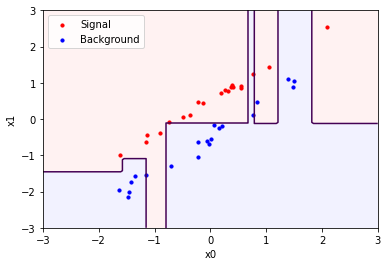

In [11]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(
    criterion='gini',
    # criterion='entropy',
    splitter='best',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=1,
)

# データ点の取得
x, t = get_dataset_for_classification(mode='difficult')

# データを45度回転させると、決定木でも簡単にモデリング可能
# theta = 1. / np.sqrt(2)
# x = np.dot(x, np.array([[theta, theta], [-theta, theta]]))

# フィット
model.fit(x, t)

# プロット
plot_prediction(model.predict)
plot_datapoint(x, t)

# ランダムフォレスト (Random forest) 
Random forestは決定木に対してバギング(Bootstrap Aggregating)をしたものです。

ランダムに抽出したデータセット(Bootstrap)に対してそれぞれ決定木を作成し、それらの平均を取ります(Aggregating)。

バギングによって、汎化性能を維持しつつ、表現力の高いモデルを実現できます。

## For Classification

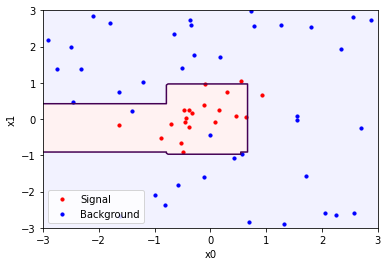

In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=10,
    criterion='gini',
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',  # max_features = n_features
    bootstrap=True,
    oob_score=False,  # out-of-bag samples
    random_state=1,
    verbose=0,
)

# データ点の取得
x, t = get_dataset_for_classification()

# フィット
_ = model.fit(x, t.ravel())

# プロット
plot_prediction(model.predict)
plot_datapoint(x, t)

### 学習したRandom Forest内の各決定木(10本)をプロット

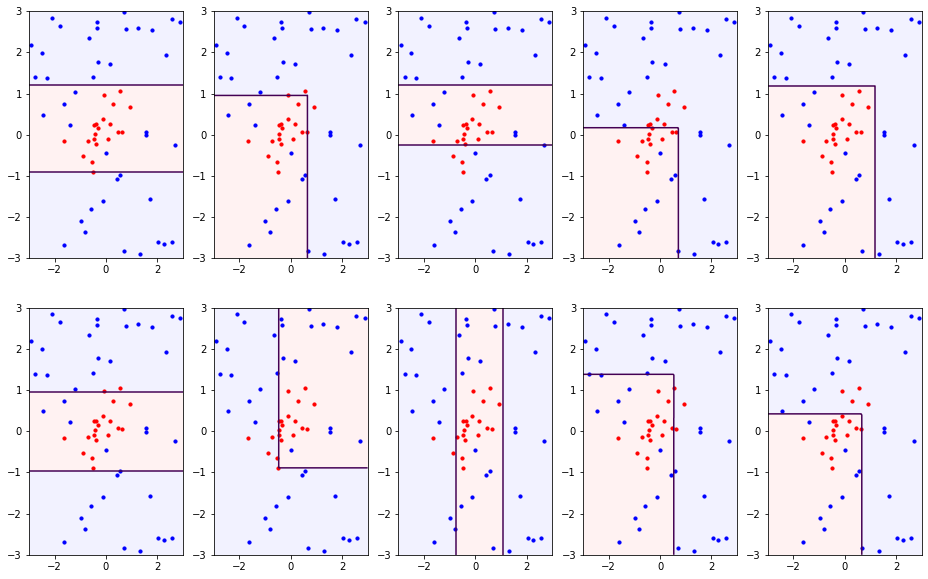

In [13]:
fig = plt.figure(figsize=(16, 10))
for i, estimator in enumerate(model.estimators_):
    ax = fig.add_subplot(2, 5, 1 + i)
    plot_prediction(lambda x: estimator.predict_proba(x)[:, 1], ax=ax)
    plot_datapoint(x, t, ax=ax)


### 決定木の中身とその予測

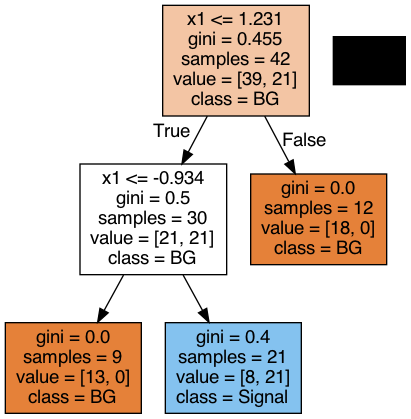

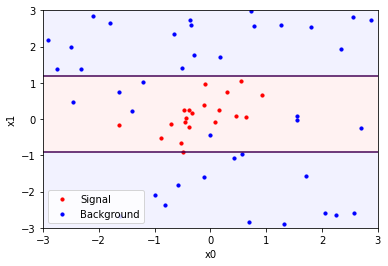

In [14]:
tree_index = 0
tree = model.estimators_[tree_index]

# 木の予測
plot_prediction(lambda x: tree.predict_proba(x)[:, 1])
plot_datapoint(x, t)

# 木の中身
from sklearn.tree import export_graphviz
dot_data = export_graphviz(
    tree,
    out_file=None,
    filled=True,
    feature_names=['x0', 'x1'],
    class_names=['BG', 'Signal'],
)

import pydotplus as pdp
graph = pdp.graph_from_dot_data(dot_data)

from IPython.display import Image
Image(graph.create_png())

# Export as png file
# graph.write_png('tmp.png')


## For Regression

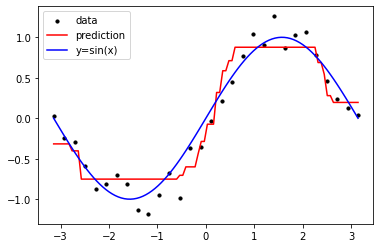

In [15]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(
    n_estimators=10,
    criterion='squared_error',
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=1,
    bootstrap=True,
    oob_score=False,  # out-of-bag samples
    random_state=1,
    verbose=0,
)

# データ点の取得
x, t = get_dataset_for_regression()

# フィット
_ = model.fit(x, t.ravel())

# プロット
x_grid = np.linspace(-np.pi, np.pi, 100)[:, np.newaxis]
plt.scatter(x, t, s=10, c='black', label='data')  # データ点のプロット
plt.plot(x_grid, model.predict(x_grid), c='red', label='prediction')
plt.plot(x_grid, np.sin(x_grid), c='blue', label='y=sin(x)')
plt.legend()
plt.show()

### 学習したRandom Forest内の各決定木(10本)をプロット

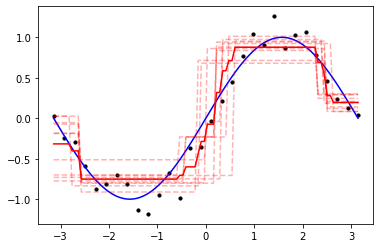

In [16]:
x_grid = np.linspace(-np.pi, np.pi, 100)[:, np.newaxis]
plt.scatter(x, t, s=10, c='black', label='data')  # データ点のプロット
plt.plot(x_grid, np.sin(x_grid), c='blue', label='y=sin(x)')

for estimator in model.estimators_:
    plt.plot(x_grid, estimator.predict(x_grid), c='red', alpha=0.3, linestyle='dashed', label='prediction')

_ = plt.plot(x_grid, model.predict(x_grid), c='red', label='prediction (ensemble)')


# Adaboost
ここでは弱学習器に決定木を使用し、Adaptive boostingでBoostingをしてみます。

## For Classification

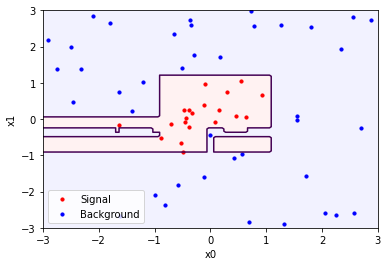

In [17]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        max_depth=2,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=1,
    ),
    n_estimators=100,
    learning_rate=1,
    # algorithm='SAMME.R',
    algorithm='SAMME',
    random_state=1,
)

# データ点の取得
x, t = get_dataset_for_classification()

# フィット
_ = model.fit(x, t.flatten())

# プロット
plot_prediction(model.predict)
plot_datapoint(x, t)

### Boosting中の各データ点・各弱学習器に対する重みの計算
Adapting boostingでは以下のようにしてデータ点に関する重み($w_n^{(m)}$)、各弱教師器に対する重み($\alpha_m$)が計算されています。

$$
\begin{align*}
\epsilon_m &= \frac{\sum_{n=1}^{N} w_n^{(m)} I(y_m(x_n)\neq t_n)}{\sum_{n=1}^{N} w_n^{(m)}} \\
\alpha_m &= \ln\left\{ \frac{1 - \epsilon_m}{\epsilon_m} \right\} \\
w_n^{(m+1)} &= w_n^{(m)} \exp \{ \alpha_m I(y_m(x_n)\neq t_n) \}
\end{align*} \\
$$

(各弱教師器に対する重み($\alpha_m$)は`model.estimator_weights_`のようにして取得することもできます。)

In [18]:
# Adapting boostingの各ステップにおける、各データ点に対する重みを計算
sample_weights = []

w = np.ones(len(t)) / len(t)
sample_weights += [np.copy(w)]

for tree in model.estimators_:
    y = tree.predict(x)
    incorrect = (y != t.ravel())
    epsilon = (w * incorrect).sum() / w.sum()
    alpha = np.log((1. - epsilon) / epsilon)

    w *= np.exp(alpha * incorrect)
    w /= w.sum()
    sample_weights += [np.copy(w)]


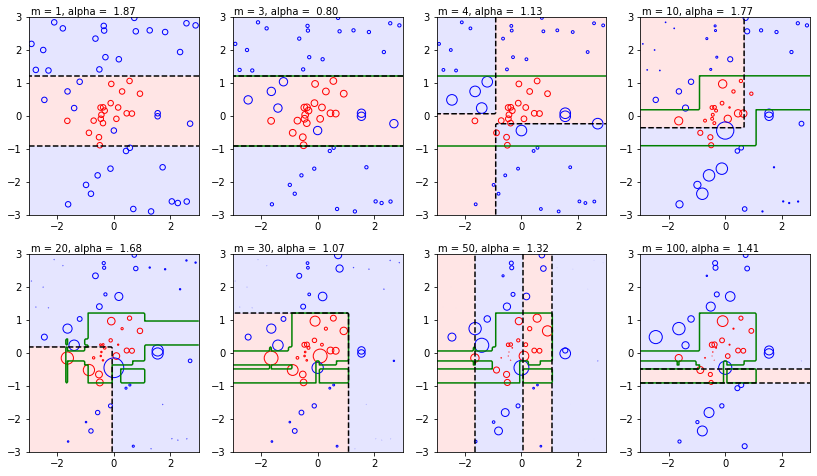

In [19]:
# 等高線を描くためのメッシュの生成
x1, x2 = np.mgrid[-3:3:100j, -3:3:100j]
x_grid = np.array([x1.flatten(), x2.flatten()]).T
model_staged_predict = list(model.staged_predict(x_grid))

# シグナル/バックグラウンドの抽出
cut_sig = t[:, 0] == 1
cut_bg = t[:, 0] == 0

fig = plt.figure(figsize=(14, 8))
for i, i_boost in enumerate([0, 2, 3, 9, 19, 29, 49, 99]):
    ax = fig.add_subplot(2, 4, 1 + i)

    # 一つ前のステップにおける(アンサンブルされた)予測 (緑線)
    if i_boost > 0:
        y = model_staged_predict[i_boost - 1]
        cs = ax.tricontour(x1.flatten(), x2.flatten(), y.flatten(), levels=[0.5], extend='max', colors='green')

    # そのステップにおける弱学習器の予測 (黒点線 = 境界、赤/黒 = 1/0)
    y = model.estimators_[i_boost].predict(x_grid)
    if y.min() < 0.5 and 0.5 < y.max():
        cs = ax.tricontour(x1.flatten(), x2.flatten(), y.flatten(), levels=[0.5], extend='max', linestyles='dashed', colors='black')
        cs = ax.contourf(x1, x2, y.reshape((100, 100)), levels=[-0.1, 0.5, 1.5], alpha=0.1, colors=['blue', 'red'])

    ## プロット用に各データ点の重みを適当な大きさに正規化
    w = sample_weights[i_boost] * len(t) * 30

    ## データ点をプロット
    ax.scatter(x[cut_sig][:, 0], x[cut_sig][:, 1], label='Signal', c='none', s=w[cut_sig], edgecolor='red')
    ax.scatter(x[cut_bg][:, 0], x[cut_bg][:, 1], label='Background', c='none', s=w[cut_bg], edgecolor='blue')

    ax.text(0.01, 1.01, f'm = {i_boost + 1}, alpha = {model.estimator_weights_[i_boost]: 2.2f}', transform=ax.transAxes)


## For Regression

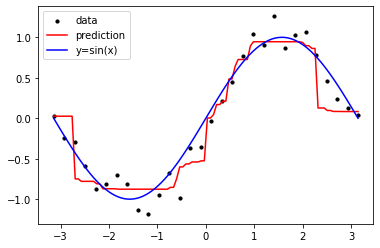

In [20]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(
        criterion='squared_error',
        splitter='best',
        max_depth=2,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=1,
        random_state=1,
    ),
    n_estimators=100,
    learning_rate=1,
    # loss='linear',
    loss='square',
    # loss='exponential',
    random_state=1,
)

# データ点の取得
x, t = get_dataset_for_regression()

# フィット
_ = model.fit(x, t.ravel())

# プロット
x_grid = np.linspace(-np.pi, np.pi, 100)[:, np.newaxis]
plt.scatter(x, t, s=10, c='black', label='data')  # データ点のプロット
plt.plot(x_grid, model.predict(x_grid), c='red', label='prediction')
plt.plot(x_grid, np.sin(x_grid), c='blue', label='y=sin(x)')
plt.legend()
plt.show()

### 学習したAdaBoost(+DecisionTree)内の各決定木(100本)をプロット

RegressionのAdaBoost (AdaBoost.R2) では、弱学習器の重み付きのメディアンの値が最終的な予測値として用いられます。

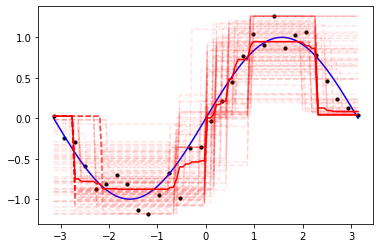

In [21]:
x_grid = np.linspace(-np.pi, np.pi, 100)[:, np.newaxis]
plt.scatter(x, t, s=10, c='black', label='data')  # データ点のプロット
plt.plot(x_grid, np.sin(x_grid), c='blue', label='y=sin(x)')

for estimator in model.estimators_:
    plt.plot(x_grid, estimator.predict(x_grid), c='red', alpha=0.1, linestyle='dashed', label='prediction')

_ = plt.plot(x_grid, model.predict(x_grid), c='red', label='prediction (ensemble)')


RegressionにおけるAdapting boostingでは以下のようにしてデータ点に関する重み($w_n^{(m)}$)、各弱教師器に対する重み($\alpha_m$)が計算されています。

$$
\begin{align*}
\epsilon_n &= |y_n(x)-t_n| \\
D &= \max \epsilon_n \\
\mathcal{L}_n &= \epsilon/D & \mathrm{(linear \ loss)} \\
\mathcal{L}_n &= \epsilon^2 / D^2 & \mathrm{(square \ loss)} \\
\mathcal{L}_n &= 1 - \exp\left(-\epsilon/D \right) & \mathrm{(exponential \ loss)} \\
\mathcal{L}_{\rm ave} &= \sum_n w_n^{(m)} \mathcal{L}_n \\
\beta &= \frac{\mathcal{L}_{\rm ave}}{1 - \mathcal{L}_{\rm ave}} \\
\alpha_m &= \ln\left( 1/\beta \right) \\
w_n^{(m+1)} &= w_n^{(m)} \beta^{1 - \mathcal{L}_n}
\end{align*}
$$

(各弱教師器に対する重み($\alpha_m$)は`model.estimator_weights_`、重み付きのロスは`model.estimator_errors_`のようにして取得することもできます。)

詳細は次の論文を参照: Drucker. “Improving Regressors using Boosting Techniques”, 1997.

In [22]:
# Adapting boostingの各ステップにおける、各データ点に対する重みを計算
sample_weights = []

w = np.ones(len(t)) / len(t)
sample_weights += [np.copy(w)]

for tree in model.estimators_:
    y = tree.predict(x)
    err = np.abs(y - t.ravel())

    # loss = err / err.max()  # if loss is linear
    loss = (err / err.max()) ** 2  # if loss is square
    # loss = 1 - np.exp(-(err / err.max()))  # if loss is exponential

    loss_ave = (w * loss).sum()  # 重み付きのロス
    beta = loss_ave / (1. - loss_ave)
    alpha = np.log(1. / beta)

    w *= np.power(beta, 1. - loss)
    w /= w.sum()
    sample_weights += [np.copy(w)]


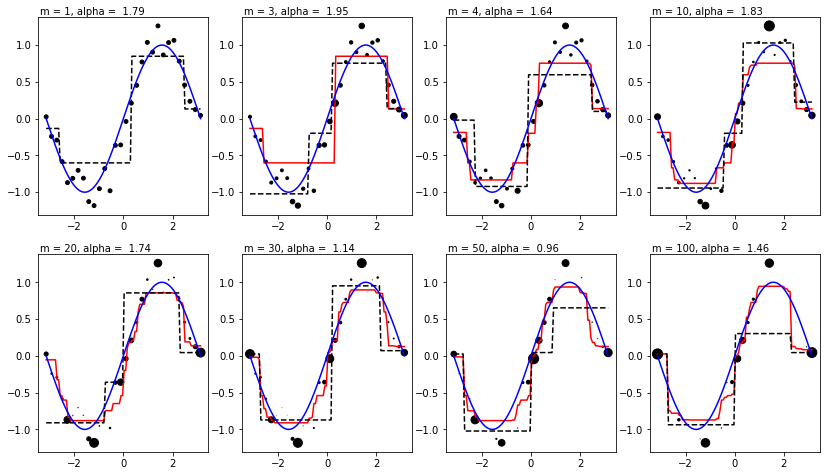

In [23]:
x_grid = np.linspace(-np.pi, np.pi, 100)[:, np.newaxis]
model_staged_predict = list(model.staged_predict(x_grid))

fig = plt.figure(figsize=(14, 8))
for i, i_boost in enumerate([0, 2, 3, 9, 19, 29, 49, 99]):
    ax = fig.add_subplot(2, 4, 1 + i)

    # プロット
    msize = sample_weights[i_boost] * len(t) * 15
    ax.scatter(x, t, c='black', label='data', s=msize)  # データ点のプロット

    # 一つ前のステップにおける(アンサンブルされた)予測 (赤線)
    if i_boost > 0:
        ax.plot(x_grid, model_staged_predict[i_boost - 1], c='red', label='prediction')
    
    # そのステップにおける弱学習器の予測 (黒点線)
    ax.plot(x_grid, model.estimators_[i_boost].predict(x_grid), c='black', linestyle='dashed', label='prediction')

    # 理想的な予測線
    ax.plot(x_grid, np.sin(x_grid), c='blue', label='y=sin(x)')

    ax.text(0.01, 1.01, f'm = {i_boost + 1}, alpha = {model.estimator_weights_[i_boost]: 2.2f}', transform=ax.transAxes)


# Gradient boosting
Gradient boostingは、それまでのモデル予測と正解ラベルの残差(residual)を目的変数として弱学習器の学習を進める手法です。

## For Regression

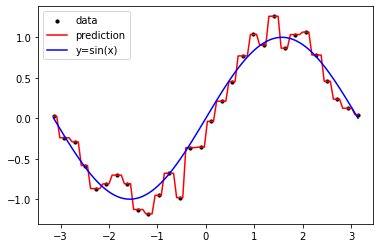

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=1,
    n_estimators=100,
    subsample=1.0,
    criterion='squared_error',
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=2,
    max_features=1,
    validation_fraction=0.1,
    n_iter_no_change=None,
    random_state=1,
    verbose=0,
)

# データ点の取得
x, t = get_dataset_for_regression()

# フィット
_ = model.fit(x, t.ravel())

# プロット
x_grid = np.linspace(-np.pi, np.pi, 100)[:, np.newaxis]
plt.scatter(x, t, s=10, c='black', label='data')  # データ点のプロット
plt.plot(x_grid, model.predict(x_grid), c='red', label='prediction')
plt.plot(x_grid, np.sin(x_grid), c='blue', label='y=sin(x)')
plt.legend()
plt.show()

各ステップでは、残差
$$
h_m(x) = -\left. \frac{\partial \mathcal{L}(t_i, F(x))}{\partial F(x)} \right|_{F=F_{m-1}}
$$
を目的変数とします。ロスに二乗和誤差を使う場合、残差は$h_m(x) = -(F_{m-1}(x) - t_i)$となります。

In [25]:
# Gradient boostingの各ステップにおける、各データ点に対する残差を計算 (square lossの例)
residuals = [-(y - t.ravel()) for y in zip(model.staged_predict(x))]

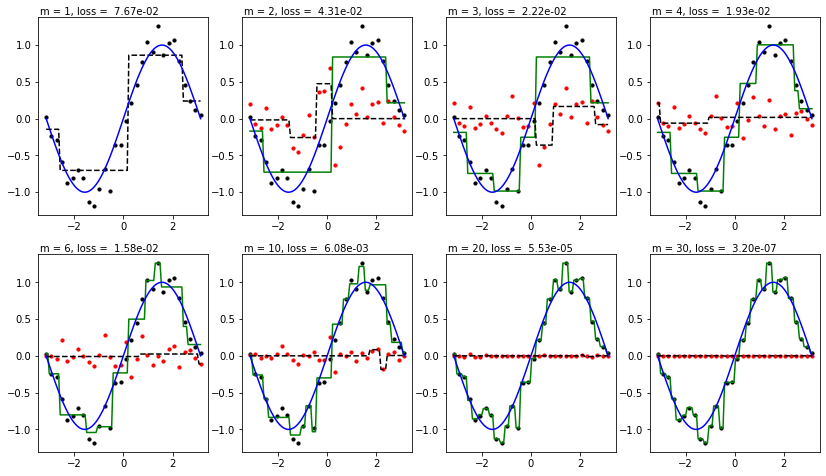

In [26]:
x_grid = np.linspace(-np.pi, np.pi, 100)[:, np.newaxis]
model_staged_predict = list(model.staged_predict(x_grid))

fig = plt.figure(figsize=(14, 8))
# for i, i_boost in enumerate([0, 2, 3, 9, 19, 29, 49, 99]):
for i, i_boost in enumerate([0, 1, 2, 3, 5, 9, 19, 29]):
    ax = fig.add_subplot(2, 4, 1 + i)

    # プロット
    ax.scatter(x, t, c='black', label='data', s=10)  # データ点のプロット

    # 一つ前のステップにおける(アンサンブルされた)予測 (緑線) と 残差 (赤点)
    if i_boost > 0:
        ax.scatter(x, residuals[i_boost - 1], c='red', label='residual', s=10)  # データ点のプロット
        ax.plot(x_grid, model_staged_predict[i_boost - 1], c='green', label='prediction')

    # そのステップにおける弱学習器の予測 (黒点線)
    ax.plot(x_grid, model.estimators_[i_boost][0].predict(x_grid), c='black', linestyle='dashed', label='prediction')

    # 理想的な予測線
    ax.plot(x_grid, np.sin(x_grid), c='blue', label='y=sin(x)')

    ax.text(0.01, 1.01, f'm = {i_boost + 1}, loss = {model.train_score_[i_boost]: 2.2e}', transform=ax.transAxes)


Gradient boostingは過学習を起こしやすいので注意が必要です。

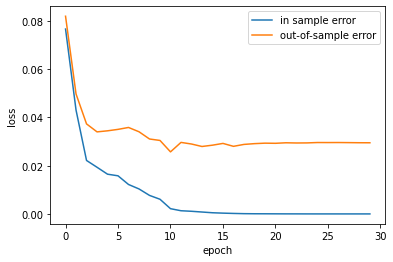

In [27]:
# トレーニングサンプルに対するロスの推移
loss_train = [((y - t.ravel()) ** 2).mean() for y in zip(model.staged_predict(x))] 

# 真の分布に対するロスの推移
x_grid = np.linspace(-np.pi, np.pi, 1000)[:, np.newaxis]
loss_test = [((y - np.sin(x_grid).ravel()) ** 2).mean() for y in zip(model.staged_predict(x_grid))] 

# プロット
plt.plot(loss_train[:30], label='in sample error')
plt.plot(loss_test[:30], label='out-of-sample error')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()